# HaMLeT

## Session 3: Feature Extraction

### Goals of this Session

In this session you will ...
* get an understanding of why feature descriptors are superior to raw data
* be able to think of abstract representations of image data
* have implemented a feature descriptor on your own
* have gotten to know several common descriptors
* have used feature representations for image classifciation

### Local Binary Pattern

Local Binary Pattern is a simple feature descriptor. It compares the eight neighbouring pixel values to the center pixel value -- if it's larger, the value 1 is assigned to this pixel and 0 otherwise. The resulting 8 bit number is stored as an integer (in the range of 0--255). This is the local feature descriptor for a single pixel. For this exercise, the least significant bit should be in the upper right corner and the significance increases clockwise.

Useful hints:
* `2 ** 7` computes 2^7.
* There is `+=` operator in python!

**Task:** Implement Local Binary Pattern and test it on a few random 3x3 matrices.

In [1]:
import numpy as np

def local_binary_pattern(input_matrix):
    # input matrix is a numpy array of size 3 x 3
    # return value should be an integer number between 0 and 255.

    lbp_matrix = (input_matrix[1][1] < input_matrix).astype(int)
    lbp_string = str(lbp_matrix[0][2]) + str(lbp_matrix[1][0]) + str(lbp_matrix[1][2]) + str(lbp_matrix[2][2]) \
    + str(lbp_matrix[2][1]) + str(lbp_matrix[2][0]) + str(lbp_matrix[0][0]) + str(lbp_matrix[0][1])
    lbp = int(lbp_string[::-1], 2)
    return lbp

# Test with some random numbers
for i in range(2):
    random_matrix = np.random.randint(255, size=(3, 3))
    lbp = local_binary_pattern(random_matrix)
    print('Random Matrix:\n', random_matrix, '\nLBP: ', lbp, '\n')

Random Matrix:
 [[207 105 173]
 [ 63  14 104]
 [207  33   7]] 
LBP:  247 

Random Matrix:
 [[ 43 199 142]
 [178 173  65]
 [211 189 141]] 
LBP:  178 



Now we'd like to use this local feature descriptor to convert an entire image to a more compact representation of itself. Often, LBP is used with a histogram.

Useful hints:

* `numpy` has a `histogram` function!
* Use the for-loop and ignore the border pixels (no padding required)

**Task:** Implement Local Binary Pattern for a whole image. 

In [2]:
def local_binary_pattern_histogram(input_image):
    # input_image is an image of arbitrary size
    # return a 256 entires long list or array that contains 
    # the local binary pattern histogram values.

    res = []
        
    for i in range(1, input_image.shape[0] - 1):
        for j in range(1, input_image.shape[1] - 1):
            # your code here
            input_matrix = input_image[i-1:i+2, j-1:j+2]
            out = local_binary_pattern(input_matrix)
            res.append(out)
    
    histogram, bins = np.histogram(res, bins=256)
            
    return histogram

[17111  1431  3239   383  3227  2752   384   250  1300   155   343    47
  2494  4611   228   190  2656   252   347    38   351   395    39    20
  2525   201   451    51  5028  7323   201   141  1340   209  2495   323
   351   289   250   276   154    29   245    40   199   238   236   275
  2552   298  4868   433   455   402   200   243  4313   281  6865   448
  6144  4049  2719  1906  1327   183  2584   214   341   210   254   235
   196    31   308    36   296   274   272   280   268    43   330    52
    56    38    34    55   300    30   390    60   421   428   278   351
   149    29  4540   230    61    35   176   261    29     9   260    47
    41    37   280   497   195    38  7176   423    51    50   155   322
   287    55  3895   400   528   406  1831  2637  2766  2661   393   414
   345  5376    45   218   274   195    40    58   316  7386    47   146
   253   226    21    35    29   151     5    25   190   215    26    56
   159  2651    24   115   275   308   369   407   

<BarContainer object of 256 artists>

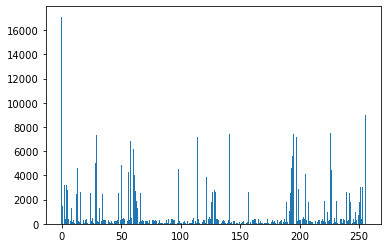

In [3]:
%matplotlib inline
import cv2
from matplotlib import pyplot

# this is just a sample image (and we'll only take the first channel
# as it's grayscale, it's the same as the other two channels anyway)
sample_image = cv2.imread('sample.jpg')[:, :, 0]
hist = local_binary_pattern_histogram(sample_image)

print(hist)

pyplot.bar(range(256), hist)


Now we have an abstract representation of our image! Instead of using 512 x 512 = 262'144 raw intensity values, we've condensed the image into a feature vector of length 256.



### Classification 

We'd like to use feature descriptors such as LBP for image classification. In this section you'll apply feature descriptors to images and use a simple classifier to assign one of two classes to the image.

Before we can start, we have to overcome a few challenges. First of all, the dataset contains images of arbitrary size. Usually, you either extract images from patches with a fixed size or you implement feature detectors that are size independent. The latter can be done for example by normalising the histogramm. Normalising / scaling feature values is generally a good practise.

**Task**: Write a normalisation method that normalises a given histogram.

<BarContainer object of 256 artists>

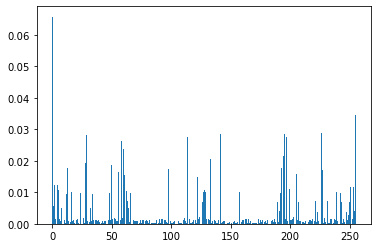

In [4]:
def normalise_histogram(hist):
    normalised_histogram = hist / np.sum(hist)
    return normalised_histogram

pyplot.bar(range(256), normalise_histogram(hist))

We're going to use this, but we'll also extract image patches (some methods later require that). In this case, we'll extract only one large, square patch per image and resize it to a fixed size.

Here is a method that preprocesses the image by 
* converting to grayscale
* extracting a square patch from the centre
* resize the patch to a given fixed size.

Take a look at it to see how it works.

In [5]:
def extract_patch(input_image, fixed_size=256):
    gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    tmp_size = min(gray_image.shape)
    offsets = [(gray_image.shape[i] - tmp_size) // 2 for i in (0, 1)]
    patch = gray_image[offsets[0]: offsets[0] + tmp_size, offsets[1]: offsets[1] + tmp_size]
    return cv2.resize(patch, (fixed_size, fixed_size))

See how it works with a sample image.

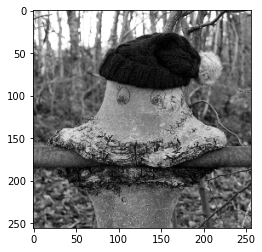

In [6]:
sample_image = cv2.imread('sample_large.jpg')
patch = extract_patch(sample_image)
pyplot.imshow(patch, cmap='gray')

Now, let's load our dataset!
We'll use [CalTech 101](http://www.vision.caltech.edu/Image_Datasets/Caltech101) dataset, which contains images from 101 classes of object. For this task, we'll try to create a classifier that can distinguish soccer balls and pyramids. Here is a method that returns four list of image data: two with labels (0 = emu, 1 = mayfly) and two with the actual images for training and testing, respectively.

In [7]:
from torchvision.datasets import Caltech101
import os, glob

dset_path = os.path.join(os.path.abspath(os.environ["HOME"]), 'datasets')

print(dset_path)
if not os.path.exists(os.path.join(dset_path, 'caltech101', '101_ObjectCategories')):
    ds = Caltech101(dset_path, download=True)
    
def load_dataset(train_percentage=0.7, maxnum=1000):
    images, labels = [], []
    for labelNum, labelName in enumerate(['emu', 'mayfly']):
        cnt = 0
        image_list = glob.glob(os.path.join(dset_path, 'caltech101', '101_ObjectCategories', labelName, '*.jpg'))
        for imagePath in image_list[:maxnum]:
            images.append(cv2.imread(imagePath))
            labels.append(labelNum)
            cnt += 1
        print('Loaded ', cnt, ' images of class ', labelName)
    np.random.seed(11)
    np.random.shuffle(images)
    np.random.seed(11)
    np.random.shuffle(labels)
    split = int(len(labels) * train_percentage)
    return np.array(images[:split]), np.array(labels[:split]), np.array(images[split:]), np.array(labels[split:])

train_data, train_labels, test_data, test_labels = load_dataset()

/Users/philippbraun/datasets
Loaded  53  images of class  emu
Loaded  40  images of class  mayfly


/Users/philippbraun/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Let's visualise a few of these images!

mayfly
emu
emu
emu


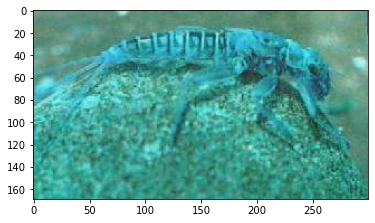

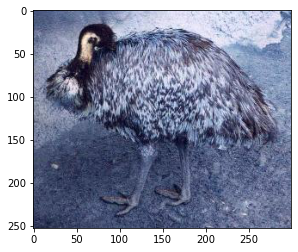

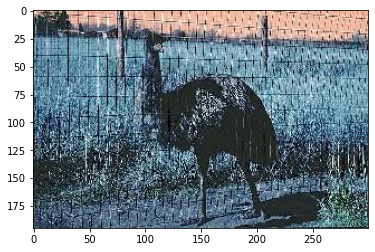

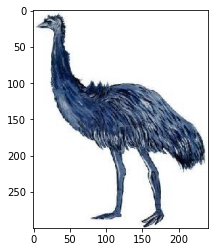

In [8]:
label_names = ['emu', 'mayfly']

print(label_names[train_labels[0]])
print(label_names[test_labels[0]])
print(label_names[train_labels[1]])
print(label_names[test_labels[1]])

pyplot.figure()
pyplot.imshow(train_data[0])

pyplot.figure()
pyplot.imshow(test_data[0])

pyplot.figure()
pyplot.imshow(train_data[1])

pyplot.figure()
pyplot.imshow(test_data[1])

**Task:** convert the train and test data into a suitable format and apply feature extraction with a normalised local binary pattern histogram. For a good trade-off between computational performance and accuracy, use an image size of 256 x 256 pixels.

Useful hints:

* data is a list of images -- for each item in the list, extract the patch and compute the feature vector of the patch
* list comprehensions are amazing: `new_list = [operation(item) for item in old_list]` should be really useful!

In [9]:
def create_feature_vectors(data):
    # data is a list of images, feature_data is a list of corresponding feature vectors
    
    feature_data = [normalise_histogram(local_binary_pattern_histogram(extract_patch(image))) for image in data]
            
    return feature_data

train_features = np.array(create_feature_vectors(train_data))
test_features = np.array(create_feature_vectors(test_data))

Alright, let's get to the fun part: Classification! You know how to handle this, the only difference is that we'll use our own features extracted from images instead of precomputed ones. Don't worry if the numbers have no real meaning to you anymore -- as long as they provide a good separation between the classes, we'll be fine!

**Task:** Implement methods to train and test classification using feature descriptors with an SVM!

Useful hints:

* you can write methods on your own, but `sklearn` has stuff like `sklearn.preprocessing.StandardScaler` and `sklearn.metrics.accuracy_score` built in already!

In [34]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def train_and_test(train_data, train_labels, test_data, test_labels):
    # use a linear SVM, a StandardScaler and return the accuracy!
        
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(train_data, train_labels)
    pred = clf.predict(test_data)
    accuracy = accuracy_score(pred, test_labels)
    
    return accuracy

print('Test Features')
train_and_test(train_features, train_labels, test_features, test_labels)

Test Features


0.75

Let's compare that to the original raw data!

In [35]:
train_raw = [extract_patch(datum, fixed_size=256).reshape(-1) for datum in train_data]
test_raw = [extract_patch(datum, fixed_size=256).reshape(-1) for datum in test_data]

print('Test Raw')
train_and_test(train_raw, train_labels, test_raw, test_labels)


Test Raw


0.7857142857142857

Apparently, we're at least a little better than raw data. 

Let's check some other feature descriptors. Many of them are already implemented, for example in `scikit image`. Let's check their implementation of the LBP feature descriptor.

**Task:** Write a method that converts a list of images into a list of lbp features using the `skimage_lbp` method. Read up in the documentation about variations and implement a `uniform` version. Remember to also implement histogram functions with arbitrary lengths, as the `uniform` variant returns fewer than 256 bins.

Test Features


0.75

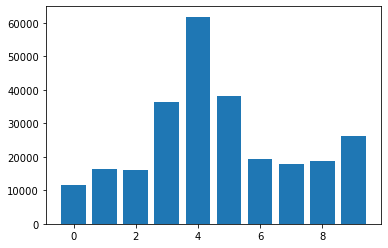

In [76]:
from skimage.feature import local_binary_pattern as skimage_lbp

def skimage_lbp_histogram(input_image):
    # input_image is an image of arbitrary size
    # return a 256 entires long list or array that contains the 
    # local binary pattern histogram values.
        
    lbp = skimage_lbp(input_image, P=8, R=1, method="uniform")
    lbp_histogram, bins = np.histogram(lbp)
    
    
    return lbp_histogram

def create_feature_vectors(data):
    # data is a list of images, feature_data is a list of corresponding feature vectors
    # list comprehensions are a pythonic way to handle lists, btw. It might come in handy here!
    feature_data = [normalise_histogram(skimage_lbp_histogram(extract_patch(image))) for image in data]
    return feature_data

sample_image = cv2.imread('sample.jpg')[:, :, 0]
hist = skimage_lbp_histogram(sample_image)
pyplot.bar(range(len(hist)), hist)

train_features = np.array(create_feature_vectors(train_data), dtype=np.float64)
test_features = np.array(create_feature_vectors(test_data), dtype=np.float64)

print('Test Features')
train_and_test(train_features, train_labels, test_features, test_labels)

**Task:** Use the new features to perform classification. 

*Question: Even if the results with feature descriptors are slightly poorer (which may also be due to a small and unsuitable training set), applying features has several advantages. Use the `uniform` version of LBP to explain some of them.*

**Your answer:** ...

Uniform version is grayscale and rotation invariant.

### More Feature Descriptors

In image processing, there are several feature descriptors that common and already implemented -- just like the LBP descriptor you saw earlier. 

**Task:** Try the HOG feature descriptor. How well does it perform? Use the `visualise=True` parameter and visualise the result of the feature descriptor.

*Question:* What do you see, how can you interpret the HOG features? What is your opinion about the number of returned features?
**Your answer:** A number of gradients is returned that is flattened based on applying a grid to the image.

324


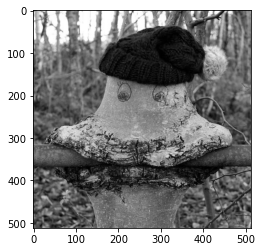

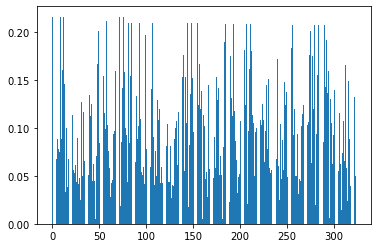

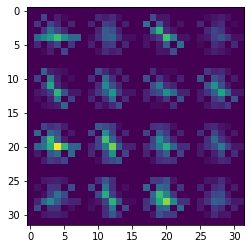

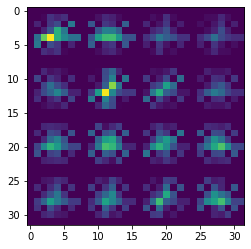

Test Features


0.9642857142857143

In [74]:
from skimage.feature import hog as skimage_hog

def create_feature_vectors(data):
    # data is a list of images, feature_data is a list of corresponding feature vectors
    
    feature_data = []
    
    for image in data:
        fd, hog_image = skimage_hog(extract_patch(image, fixed_size=32), block_norm='L2-Hys', visualize=True)
        pyplot.imshow(hog_image)
        feature_data.append(fd)
            
    pyplot.show()
        
    return feature_data


sample_image = cv2.imread('sample.jpg')
# implement img such that img is a representation of hog

pyplot.imshow(sample_image)

hist = skimage_hog(extract_patch(sample_image, fixed_size=32), block_norm='L2-Hys')
print(len(hist))
pyplot.figure()
pyplot.bar(range(len(hist)), hist)
pyplot.show()

train_features = np.array(create_feature_vectors(train_data), dtype=np.float64)
test_features = np.array(create_feature_vectors(test_data), dtype=np.float64)

print('Test Features')
train_and_test(train_features, train_labels, test_features, test_labels)


Often, it is useful to combine several features into one larger feature detector.

**Task:** Combine HOG, LBP and other feature descriptors in a useful way and see how it performs.

Useful hints:

* 'useful' in this case means concatenating lists
* you can concatenate two lists `list1` and `list2` into `list1` by using `extend`: `list1.extend(list2)`

334
Test Features


0.9285714285714286

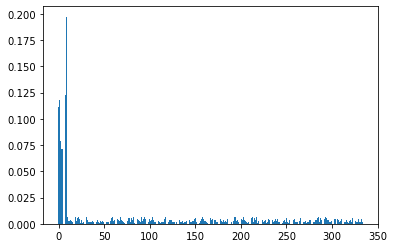

In [77]:
def combined_features(input_image):
    # compute a list that contains the entries of several feature vectors
    lbp_image=skimage_lbp(extract_patch(input_image,fixed_size=32),P=8,R=1,method='uniform')
    lbp_histogram=np.histogram(lbp_image)[0].astype('float64')
    nor_lbp_histogram=normalise_histogram(lbp_histogram)
    hog_histogram=skimage_hog(extract_patch(input_image, fixed_size=32), block_norm='L2-Hys')
    nor_hog_histogram=normalise_histogram(hog_histogram)
    combined_features =np.concatenate((nor_lbp_histogram,nor_hog_histogram))
    return combined_features

def create_feature_vectors(data):
    # data is a list of images, feature_data is a list of corresponding feature vectors
    feature_data = [combined_features(i) for i in data]
    return feature_data

sample_image = cv2.imread('sample.jpg')
hist = combined_features(sample_image)
print(len(hist))
pyplot.bar(range(len(hist)), hist)

train_features = np.array(create_feature_vectors(train_data), dtype=np.float64)
test_features = np.array(create_feature_vectors(test_data), dtype=np.float64)

print('Test Features')
train_and_test(train_features, train_labels, test_features, test_labels)

*Question:* You have used a StandardScaler (I hope). Why is this important -- particularly in this case?

**Your answer**: Standardize features by removing mean and scaling. 



### Bonus Exercises

If you're fast, there are some more interesting and challenging tasks for you! Here we go:

##### Some other SKImage Descriptors

**Task**: Try out other feature descriptors you find out, which are useful. Try to describe why / why not. You can find inspiration in this list of features (or useful methods to create features) in `skimage`: http://scikit-image.org/docs/dev/api/skimage.feature.html

In [ ]:
def some_other_skimage_features(input_image):
    features = []
    return features
    
def create_feature_vectors(data):
    # data is a list of images, feature_data is a list of corresponding feature vectors
    feature_data = []
    return feature_data

# sample_image = cv2.imread('sample.jpg')
# hist = some_other_skimage_features(sample_image)
# print(hist)

# train_features = np.array(create_feature_vectors(train_data), dtype=np.float64)
# test_features = np.array(create_feature_vectors(test_data), dtype=np.float64)


# print('Test Features')
# train_and_test(train_features, train_labels, test_features, test_labels)


*Question:* Based on the experiences you made in this session, what would you say are important properties of feature descriptors?

**Your answer:** ...



**Task**: Change the two classes `emu` and `mayfly` in the dataloader (just replace the name with any foldername in `101_ObjectCategories` on your drive) and see, which classes can be separated well with which kind of descriptor. How can you explain the differences?

##### LBP Extensions

There are several improvements to Local Binary Pattern, for example you could ...
* compare to other values than the center value (e.g. to the mean / median of the patch)
* use a larger radius than one to choose neighbour pixels
* use a look-up table for rotation invariance and other cool stuff (google for 'uniform local binary pattern')

**Task:** Implement one improvement to local binary pattern of your own choosing.

In [ ]:
def improved_local_binary_pattern(input_image):
    # input_image is an image of arbitrary size
    # return a list or array that contains the improved local binary pattern feature 
    # for the entire image
    ilbp = []
    return ilbp

Compare your descriptor against standard LBP and see how it performs!

In [ ]:
# You've written all the code necessary for this already. 
# Copy paste is a programmer's best friend ;-)

##### Your own descriptor

LBP is a rather simple feature descriptor, yet it is still often very effective. Think of other simple ways that could describe an image better than raw intensity values. 

**Task:** Implement a feature descriptor (or more general: a method that return a short list of values that describe an image) on your own!

In [ ]:
def my_own_feature_descriptor(input_image):
    feat = []
    return feat
    

**Task:** Perform classification with your own feature descriptor!

In [ ]:
# You've written all the code necessary for this already. 
# Copy paste is a programmer's best friend ;-)

# Feedback

Please give us some feedback about this session:

_enter feedback here_